# Deep Learning - Assignment - 3

    Ayush Abrol B20AI052

---

## Question 1

Perform Attribute Prediction Task on CelebA dataset for the attributes available in the dataset. For this task, use a VGG16/ResNet18 backbone and train your model in a Multi-Task Learning fashion. Report the following:
PS: I've used VGG16 as the backbone.

    1. Train the model for the prediction of 8 attributes out of 40 attributes and report the following:
        a. Mention your choice of attributes, backbone, and other parameters and the reason behind your choice.
        b. Report task-wise accuracy. 
        c. Report the overall accuracy.

### Necessary Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils, datasets, models
import warnings
warnings.filterwarnings("ignore")

/home/ayushabrol/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


### Setting the device to GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data augmentation and normalization for training, validation and test sets

In [3]:
# Define the transformations for data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(178, pad_if_needed=True),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_val_test = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define the training and testing datasets
train_dataset = datasets.CelebA(root='data', split='train', transform=transform_train, download=True)
val_dataset = datasets.CelebA(root='data', split='valid', transform=transform_val_test, download=True)
test_dataset = datasets.CelebA(root='data', split='test', transform=transform_val_test, download=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_indices, val_indices, test_indices = range(len(train_dataset)), range(len(val_dataset)), range(len(test_dataset))

### Selecting 8 attributes out of 40 attributes

In [5]:
labels = ['Bald', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Smiling','Young']
selected_indices = [i for i in range(len(labels))]

### Creating a custum dataset class

In [6]:
class SubsetCustom(Dataset):
    def __init__(self, dataset, indices, selected_indices):
        self.dataset = dataset
        self.indices = indices
        self.selected_indices = selected_indices
        
    def __getitem__(self, idx):
        image, attr = self.dataset[self.indices[idx]]
        return image, attr[self.selected_indices]
    
    def __len__(self):
        return len(self.indices)

### Building custom train, validation and test sets with only the selected 8 attributes out of 40 attributes

In [7]:
train_dataset_new = SubsetCustom(train_dataset, train_indices, selected_indices)
val_dataset_new = SubsetCustom(val_dataset, val_indices, selected_indices)
test_dataset_new = SubsetCustom(test_dataset, test_indices, selected_indices)

### Creating custom dataloaders with batch size of 128

In [8]:
train_loader = DataLoader(train_dataset_new, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset_new, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset_new, batch_size=128, shuffle=False)

In [9]:
print('Number of training samples: ', len(train_dataset_new))
print('Number of validation samples: ', len(val_dataset_new))
print('Number of testing samples: ', len(test_dataset_new))

Number of training samples:  162770
Number of validation samples:  19867
Number of testing samples:  19962


### Visualizing some sample images

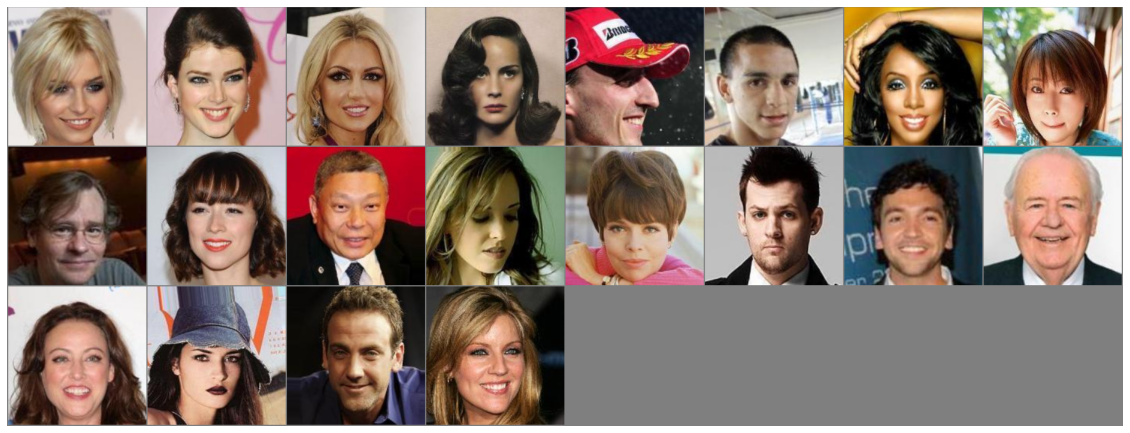

In [29]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
# increase the size of the images
plt.figure(figsize=(20, 20))
imshow(utils.make_grid(images[:20]))

### Importing the backbone model (pretrained VGG16) using torchvision models

In [10]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 8)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Using Adam optimizer with learning rate of 3e-4 and Cross Entropy Loss with number of epochs as 5

In [11]:
optimizer_vgg = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
num_epochs = 5

In [12]:
train_loss_vgg = []
val_loss_vgg = []
train_acc_vgg = []
val_acc_vgg = []

### Defining the training loop for training and validating the model

In [13]:
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs, train_loss, train_acc, val_loss_vgg, val_acc_vgg):
    for epoch in range(num_epochs):
        model.train()
        train_loss_epoch = 0
        train_acc_epoch = 0
        for (images, labels) in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs = outputs.float()
            labels = labels.float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss_epoch += loss.item()
            preds = torch.argmax(outputs, dim=1)
            labels = labels.argmax(dim=1, keepdim=True)
            train_acc_epoch += torch.sum(preds == labels).item()
        train_loss_epoch /= len(train_loader)
        train_acc_epoch /= len(train_loader.dataset)
        train_loss.append(train_loss_epoch)
        train_acc.append(train_acc_epoch)
        print("Epoch: {}/{}..".format(epoch+1, num_epochs),
                "Training Loss: {:.3f}..".format(train_loss_epoch),
                "Training Accuracy: {:.3f}".format(train_acc_epoch))
        
        model.eval()
        val_loss_epoch = 0
        val_acc_epoch = 0
        for (images, labels) in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.float()
            labels = labels.float()
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item()
            preds = torch.argmax(outputs, dim=1)
            labels = labels.argmax(dim=1, keepdims=True)
            val_acc_epoch += torch.sum(preds == labels).item()
        val_loss_epoch /= len(val_loader)
        val_acc_epoch /= len(val_loader.dataset)
        val_loss_vgg.append(val_loss_epoch)
        val_acc_vgg.append(val_acc_epoch)
        print("Epoch: {}/{}..".format(epoch+1, num_epochs),
                "Validation Loss: {:.3f}..".format(val_loss_epoch),
                "Validation Accuracy: {:.3f}".format(val_acc_epoch))


### Started training the model VGG16

In [14]:
print("Training the model VGG16..")
train(model, train_loader, val_loader, optimizer_vgg, criterion,
      num_epochs, train_loss_vgg, train_acc_vgg, val_loss_vgg, val_acc_vgg)
print("Training complete!")

### Saving the trained weights and biases and also the training and validation losses and accuracies arrays obtained during training

In [15]:
torch.save(model.state_dict(), 'models/model_vgg16.pth')
np.save('models/train_loss_vgg16.npy', np.array(train_loss_vgg))
np.save('models/val_loss_vgg16.npy', np.array(val_loss_vgg))
np.save('models/train_acc_vgg16.npy', np.array(train_acc_vgg))
np.save('models/val_acc_vgg16.npy', np.array(val_acc_vgg))

### Loading the saved models and loss and accuracy arrays

In [22]:
model.state_dict = torch.load('models/model_vgg16.pth')
train_loss_vgg = np.load('models/train_loss_vgg16.npy')
val_loss_vgg = np.load('models/val_loss_vgg16.npy')
train_acc_vgg = np.load('models/train_acc_vgg16.npy')
val_acc_vgg = np.load('models/val_acc_vgg16.npy')

### Plotting the training losses for all the 8 attributes

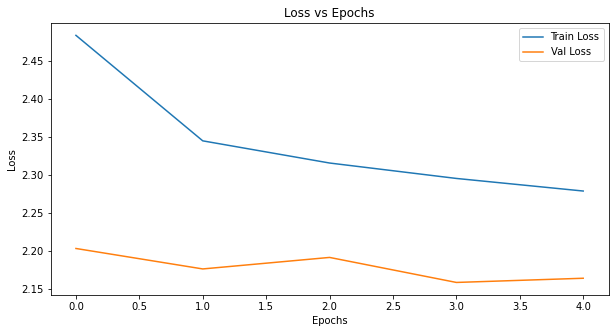

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_vgg, label='Train Loss')
plt.plot(val_loss_vgg, label='Val Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Emptying the GPU cache

In [18]:
torch.cuda.empty_cache()

### Overall Accuracy

In [ ]:
print("Testing the model VGG16..")
with torch.no_grad():
    model.eval()
    test_acc = 0
    for (images, labels) in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer_vgg.zero_grad()
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        labels = labels.argmax(dim=1, keepdim=True)
        test_acc += torch.sum(preds == labels).item()
    test_acc /= len(test_loader.dataset)
    print("Test Accuracy: {:.3f}".format(test_acc))

Tested on HPC server and outputs are stored in slurm-42602.out file

Testing the model VGG16..

Test Accuracy: 18.230

### Task-wise Accuracy

In [ ]:
# Calculating task-wise accuracy
print("Calculating task-wise accuracy..")
task_wise_acc = []
for i in range(8):
    task_wise_acc.append(0)
with torch.no_grad():
    model.eval()
    for (images, labels) in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer_vgg.zero_grad()
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        labels = labels.argmax(dim=1, keepdim=True)
        for i in range(len(labels)):
            if labels[i] == preds[i]:
                task_wise_acc[labels[i]] += 1
for i in range(8):
    task_wise_acc[i] /= len(test_loader.dataset)
    print("Task {}: {:.3f}".format(i, task_wise_acc[i]))

Tested on the HPC server and outputs are stored in slurm-42604.out file

Calculating task-wise accuracy..
- Task 0: 0.154
- Task 1: 0.011
- Task 2: 0.017
- Task 3: 0.002
- Task 4: 0.000
- Task 5: 0.004
- Task 6: 0.005
- Task 7: 0.002

**END OF QUESTION 1**